In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

df = pd.read_csv('../experiments/sw-data/amd.csv')
#df = pd.read_csv('../experiments/sw-data/gpu_sigmax.csv')
#df = pd.read_csv('../experiments/sw-data/sigmax.csv')
#df = pd.read_csv('../experiments/sw-data/debug.csv')
#df = pd.read_csv('../experiments/sw-data/power_battery.csv')

df['time'] = df['time_alloc'] + df['time_parse'] + df['time_walk']
del df['bytes_out']
df['throughput'] = df['bytes_in'] / df['time']
# df.set_index(['framework', 'api', 'allocated', 'max_values', 'num_jsons'], inplace=True)
df.sort_values(['max_values', 'throughput'], inplace=True)
display(df)

,framework,api,allocated,num_jsons,bytes_in,time_alloc,time_parse,time_walk,max_values,time,throughput
3,RapidJSON,DOM,False,7271551,134217732,2.000000e-08,6.917430e-01,4.000000e-08,1,0.691743,1.940283e+08
4,RapidJSON,DOM (in situ),False,7271551,134217732,3.000000e-08,6.099520e-01,3.000000e-08,1,0.609952,2.200464e+08
0,simdjson,DOM,False,7271551,134217732,4.000000e-08,6.900000e-07,4.081170e-01,1,0.408118,3.288701e+08
1,simdjson,DOM,True,7271551,134217732,1.554530e-04,9.700000e-07,3.574850e-01,1,0.357641,3.752858e+08
5,RapidJSON,SAX,False,7271551,134217732,1.000000e-06,3.459410e-01,3.000000e-08,1,0.345942,3.879775e+08
2,simdjson,DOM (no keys),True,7271551,134217732,1.412520e-04,1.361000e-06,3.002990e-01,1,0.300442,4.467348e+08
6,RapidJSON,SAX,True,7271551,134217732,1.272820e-04,3.000160e-01,3.000000e-08,1,0.300143,4.471788e+08
8,Boost Spirit.X3,whitespace,False,7271551,134217732,1.676520e-04,1.590050e-01,2.000000e-08,1,0.159173,8.432210e+08
7,Custom,whitespaces,False,7271551,134217732,1.621220e-04,1.341110e-01,2.000000e-08,1,0.134273,9.995873e+08
12,RapidJSON,DOM,False,6488212,134217737,2.000000e-08,6.837540e-01,4.000000e-08,2,0.683754,1.962953e+08


In [11]:
dg = df.groupby(['framework', 'max_values', 'bytes_in']).agg({'throughput':'max'})
dg.sort_values(by=['framework', 'max_values'], inplace=True)
dg['Throughput (GB/s)'] = dg.throughput * 1e-9
del dg['throughput']

display(dg)


Throughput (GB/s)
framework       max_values bytes_in                    
Boost Spirit.X3 1          134217732           0.843221
                2          134217737           0.704040
                4          134217740           0.628908
                8          134217764           0.570205
                16         134217768           0.529937
                32         134217827           0.500783
                64         134217903           0.474972
                128        134217816           0.478616
                256        134218013           0.476060
Custom          1          134217732           0.999587
                2          134217737           0.835692
                4          134217740           0.750482
                8          134217764           0.680345
                16         134217768           0.642474
                32         134217827           0.619307
                64         134217903           0.603096
                128        134217816           0.594157
                256        134218013           0.589728
RapidJSON       1          134217732           0.447179
                2          134217737           0.379886
                4          134217740           0.364653
                8          134217764           0.356985
                16         134217768           0.359503
                32         134217827           0.358040
                64         134217903           0.352450
                128        134217816           0.357994
                256        134218013           0.351788
simdjson        1          134217732           0.446735
                2          134217737           0.429703
                4          134217740           0.397562
                8          134217764           0.371928
                16         134217768           0.359326
                32         134217827           0.356014
                64         134217903           0.354893
                128        134217816           0.354231
                256        134218013           0.352958

In [12]:
dh = dg.unstack('framework')
dh.index.rename(inplace=True, names=['Max. values', 'Bytes in'])
dh = dh.droplevel(0, axis=1)
display(dh)

,framework,Boost Spirit.X3,Custom,RapidJSON,simdjson
Max. values,Bytes in,,,,
1,134217732,0.843221,0.999587,0.447179,0.446735
2,134217737,0.704040,0.835692,0.379886,0.429703
4,134217740,0.628908,0.750482,0.364653,0.397562
8,134217764,0.570205,0.680345,0.356985,0.371928
16,134217768,0.529937,0.642474,0.359503,0.359326
32,134217827,0.500783,0.619307,0.358040,0.356014
64,134217903,0.474972,0.603096,0.352450,0.354893
128,134217816,0.478616,0.594157,0.357994,0.354231
256,134218013,0.476060,0.589728,0.351788,0.352958


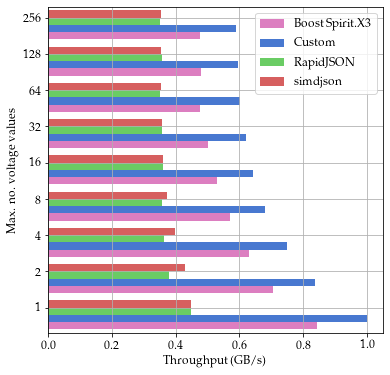

In [13]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 12
})

#dh.columns.rename(inplace=True, name='Framework')
#dh.index.rename(inplace=True, name='Max. values')

fig, ax = plt.subplots(figsize=(6, 6))
colors = ['#dc7ec0', '#4878d0', '#6acc64', '#d65f5f', '#d5bb67']

y_labels = [x[0] for x in dh.index.to_list()]
y_ticks = np.arange(0, len(y_labels))

impls = dh.columns.to_list()
bars = []
height = 1/(len(impls)+1)

for i, impl in enumerate(impls):
    x = dh[impl].to_numpy()
    y = np.arange(0, len(x))

    b = ax.barh(y=y+i*height, width=x, height=height, color=colors[i])
    bars.append(b)

ax.set_ylim(-height, len(y_labels)-height)

ax.set_yticks(y_ticks + 0.5)
ax.set_yticklabels(y_labels)
ax.set_ylabel("Max. no. voltage values")

ax.set_xlabel("Throughput (GB/s)")

ax.grid(which='both')

ax.legend(bars, impls)

fig.savefig('software.pdf')